In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
df = pd.read_csv('/kaggle/input/english-to-nepali-text/npi.txt', delimiter='\t', header=None, names=['English', 'Nepali', 'Attribution'])

df.tail()

,English,Nepali,Attribution
2684,Tom told Mary that he thought a hippopotamus c...,टमले मेरीलाई भन्यो कि उसले सोचेको थियो कि हिप्...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
2685,I don't remember how old I was when I first he...,मैले त्यो गीत पहिलो पटक सुन्दा म कति वर्षको थि...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
2686,I don't remember how many bottle of wine we dr...,"हामीले कति बोतल वाइन पियौं मलाई याद छैन, तर मल...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...
2687,The difference between the right word and almo...,सही शब्द र लगभग सही शब्द बीचको भिन्नता बत्ति र...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
2688,"When Tom was walking down the street at night,...",टमलाई राति सडकमा एक अपरिचित व्यक्तिले चक्कु दे...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [4]:
df.drop(columns=['Attribution'], inplace=True)

In [5]:
df.head()

,English,Nepali
0,Who?,को?
1,Hide.,लुकाउनुहोस्।
2,Hide.,लुक।
3,Stay.,बस्नुहोस्।
4,Hello!,नमस्ते!


In [6]:
len(df)

2689

In [7]:
english_sentences = df.loc[:, 'English']

In [8]:
nepali_sentences = df.loc[:, 'Nepali']

In [9]:
print(english_sentences[:2])
print(nepali_sentences[:2])

0     Who?
1    Hide.
Name: English, dtype: object
0             को?
1    लुकाउनुहोस्।
Name: Nepali, dtype: object


In [10]:
import unicodedata
# Unicode normalization
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [11]:
def preprocess_sentence(s):
#   s = normalize_unicode(s)
  s = s.lower()
  s = re.sub(r"([?.!।,¿])", r" \1 ", s)
  s = re.sub(r'[@#]', '', s)
  s = re.sub(r'\d+', '', s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

In [12]:
preprocessed_english = english_sentences.apply(preprocess_sentence)
preprocessed_nepali = nepali_sentences.apply(preprocess_sentence)

In [13]:
preprocessed_english.head()

0      who ?
1     hide .
2     hide .
3     stay .
4    hello !
Name: English, dtype: object

In [14]:
preprocessed_nepali.head()

0             को ?
1    लुकाउनुहोस् ।
2            लुक ।
3      बस्नुहोस् ।
4         नमस्ते !
Name: Nepali, dtype: object

In [15]:
nepali_sentences_preprocessed = preprocessed_nepali.apply(lambda x: (' ').join(['<sos>', x, '<eos>']))
english_sentences_preprocessed = preprocessed_english.apply(lambda x: (' ').join(['<sos>', x, '<eos>']))

In [16]:
nepali_sentences_preprocessed.sample(6)

2270    <sos> टम तपाईले सोचे जस्तो बुद्धिमानी छैन । <eos>
1056                     <sos> टमले जताततै खोज्यो । <eos>
2298    <sos> मलाई लाग्दैन कि यो धेरै राम्रो विचार हो ...
1949    <sos> माफ गर्नुहोस् , के तपाईं यहाँको विद्यार्...
2514    <sos> तपाईंसँग सम्पर्कमा रहन उत्तम तरिका के हो...
1400                 <sos> त्यो घर साँच्चै सानो छ । <eos>
Name: Nepali, dtype: object

In [17]:
english_sentences_preprocessed.sample(6)

1638          <sos> i am searching for my brother . <eos>
1424             <sos> tom is working with us now . <eos>
1319              <sos> tom was quicker than mary . <eos>
1425             <sos> tom lives with his parents . <eos>
2558    <sos> thanks for your suggestion . i'll think ...
2281    <sos> what's the weather like in boston now ? ...
Name: English, dtype: object

In [18]:
X_train_eng, X_test_eng, y_train_nep, y_test_nep = train_test_split(english_sentences_preprocessed, nepali_sentences_preprocessed, test_size = 0.1, random_state = 42, shuffle = True)

In [19]:
X_train_eng.head(3)

210                          <sos> i am a teacher . <eos>
1882        <sos> tom went from boston to chicago . <eos>
2640    <sos> what language do you usually use when ta...
Name: English, dtype: object

In [20]:
y_train_nep.head(3)

210                            <sos> म शिक्षक हुँ । <eos>
1882                 <sos> टम बोस्टनबाट शिकागो गए । <eos>
2640    <sos> तपाइँ सामान्यतया टमसँग कुन भाषामा बोल्नु...
Name: Nepali, dtype: object

In [21]:
def create_word_list_and_tokenize(x):
    # Build the word list from the training data
    word_list = [word for sent in x for word in sent.split()]

    # Count word frequencies
    corpus_ = Counter(word_list)

    # Create the one-hot dictionary
    vocab = {w: i + 2 for i, (w, _) in enumerate(corpus_.items())}  # Start indexing from 2 (0 reserved for padding, 1 for unknown word)
    vocab['<pad>'] = 0  # Padding token
    vocab['<unk>'] = 1  # Unknown word token

    # Tokenize the training data
    final_list_train = []
    for sent in x:
        tokenized_sent = [vocab.get(word, 1) for word in sent.split()]  # Use vocab.get() to handle unknown words
        final_list_train.append(tokenized_sent)


    return (np.array(final_list_train, dtype=object), vocab)

In [22]:
english_tokens_train, english_vocab_train = create_word_list_and_tokenize(X_train_eng)
english_tokens_test, english_vocab_test = create_word_list_and_tokenize(X_test_eng)

In [23]:
len(english_vocab_train)

1914

In [24]:
english_tokens_train[3]

[2, 17, 18, 25, 26, 13, 27, 18, 24, 8]

In [25]:
nepali_tokens_train, nepali_vocab_train = create_word_list_and_tokenize(y_train_nep)
nepali_tokens_test, nepali_vocab_test = create_word_list_and_tokenize(y_test_nep)

In [26]:
def create_inverse_vocab(vocab):
    """
    Create an inverse vocabulary mapping from a given vocabulary.
    
    Args:
    - vocab (dict): Vocabulary mapping (word to token).
    
    Returns:
    - Inverse vocabulary mapping (token to word).
    """
    inv_vocab = {token: word for word, token in vocab.items()}
    return inv_vocab

In [27]:
inv_nepali = create_inverse_vocab(nepali_vocab_train)

In [28]:
nepali_tokens_train[3]

[2, 19, 20, 21, 22, 23, 24, 25, 26, 18, 7]

In [29]:
len(nepali_vocab_train)

2879

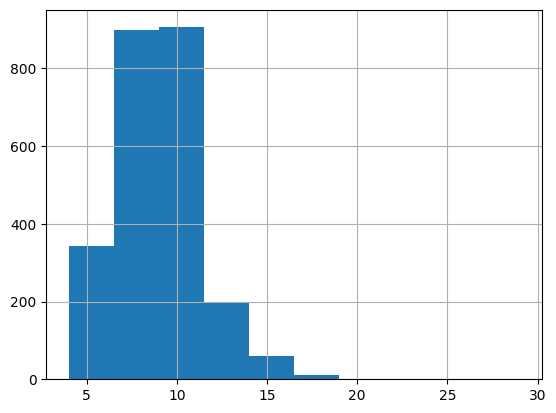

count    2420.000000
mean        8.773554
std         2.289858
min         4.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        29.000000
dtype: float64

In [30]:
rev_len = [len(i) for i in english_tokens_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [31]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, :len(review)] = np.array(review)[:seq_len]
    return features

In [32]:
x_train_pad_eng = padding_(english_tokens_train,25)
x_test_pad_eng = padding_(english_tokens_test,25)
y_train_pad_nep = padding_(nepali_tokens_train,25)
y_test_pad_nep = padding_(nepali_tokens_test,25)

In [33]:
print(x_train_pad_eng.shape)
print(x_test_pad_eng.shape)
print(y_train_pad_nep.shape)
print(y_test_pad_nep.shape)

(2420, 25)
(269, 25)
(2420, 25)
(269, 25)


In [34]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad_eng), torch.from_numpy(y_train_pad_nep))
valid_data = TensorDataset(torch.from_numpy(x_test_pad_eng), torch.from_numpy(y_test_pad_nep))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [35]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 25])
Sample input: 
 tensor([[  2,  86, 910,  ...,   0,   0,   0],
        [  2,   9, 741,  ...,   0,   0,   0],
        [  2,   3, 252,  ...,   0,   0,   0],
        ...,
        [  2,  73,  32,  ...,   0,   0,   0],
        [  2,   9, 546,  ...,   0,   0,   0],
        [  2, 252, 896,  ...,   0,   0,   0]])
Sample output: 
 tensor([[   2,   21,  372,  ...,    0,    0,    0],
        [   2,   66,  238,  ...,    0,    0,    0],
        [   2,  189,  630,  ...,    0,    0,    0],
        ...,
        [   2,    8, 2717,  ...,    0,    0,    0],
        [   2,   39,  477,  ...,    0,    0,    0],
        [   2, 2732, 2733,  ...,    0,    0,    0]])


In [36]:
# obtain one batch of training data
dataiter = iter(valid_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 25])
Sample input: 
 tensor([[  2,  11,  67,  ...,   0,   0,   0],
        [  2,  46,  43,  ...,   0,   0,   0],
        [  2,  20,  24,  ...,   0,   0,   0],
        ...,
        [  2,  86, 525,  ...,   0,   0,   0],
        [  2, 417,  62,  ...,   0,   0,   0],
        [  2,  20,  66,  ...,   0,   0,   0]])
Sample output: 
 tensor([[  2, 174, 111,  ...,   0,   0,   0],
        [  2, 612, 115,  ...,   0,   0,   0],
        [  2,  18, 655,  ...,   0,   0,   0],
        ...,
        [  2,  86, 131,  ...,   0,   0,   0],
        [  2, 512, 513,  ...,   0,   0,   0],
        [  2,  81, 522,  ...,   0,   0,   0]])


In [37]:
eos_index_train = nepali_vocab_train["<eos>"]
sos_index_train = nepali_vocab_train["<sos>"]

In [38]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.rnn = nn.LSTM(input_size = emb_dim, hidden_size = hid_dim, num_layers = n_layers, dropout=dropout, batch_first= True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        
        return outputs, hidden, cell

In [39]:
# an Embedding module containing 10 tensors of size 3
trg = torch.zeros(50, 25)
# a batch of 2 samples of 4 indices each
trg[0, :].shape

torch.Size([25])

In [40]:
x = torch.zeros(2, 1, 2, 1, 2)
print(x.size())
y = torch.squeeze(x)
print(y.size())
y = torch.squeeze(x, 0)
print(y.size())
y = torch.squeeze(x, 1)
print(y.size())
y = torch.squeeze(x, (1, 2))
print(y.size())

torch.Size([2, 1, 2, 1, 2])
torch.Size([2, 2, 2])
torch.Size([2, 1, 2, 1, 2])
torch.Size([2, 2, 1, 2])
torch.Size([2, 2, 1, 2])


In [41]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first = True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, encoder_hidden, encoder_cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        hidden = encoder_hidden
        cell = encoder_cell
        

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc_out(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze()

        return predictions, hidden, cell 

In [42]:
check = torch.zeros(50, 2683)
check.unsqueeze(1).shape

torch.Size([50, 1, 2683])

In [43]:
test = torch.zeros(2683)
test.unsqueeze(1).shape

torch.Size([2683, 1])

In [44]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.8):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        _, hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[:,0].unsqueeze(1)

        for t in range(1, target_len):
            if len(x.shape) == 1:
                x = x.unsqueeze(0)
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)
            # Store next output prediction
            outputs[t] = output
            # Get the best word the Decoder predicted (index in the vocabulary)
            if len(output.shape) != 1:
                best_guess = output.argmax(1)
                i = 1
            else:
                best_guess = output.argmax()
                i = 0

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[:,t].unsqueeze(1) if random.random() < teacher_force_ratio else best_guess.unsqueeze(i)

        return outputs
    
    def decode(self, tokens, inv_vocab):
        """
        Translate tokens back to words using the inverse vocabulary mapping.

        Args:
        - tokens (list of lists): List of tokenized sentences.
        - inv_vocab (dict): Inverse vocabulary mapping (token to word).

        Returns:
        - List of detokenized sentences.
        """
        detokenized_sentences = []
        for tokenized_sent in tokens:
            detokenized_sent = [inv_vocab[token] for token in tokenized_sent]
            detokenized_sentences.append(detokenized_sent)
        return detokenized_sentences


In [45]:
INPUT_DIM = len(english_vocab_train)
OUTPUT_DIM = len(nepali_vocab_train)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
learning_rate = 0.001
epochs = 300

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

In [46]:
optimizer_enc = optim.Adam(enc.parameters())
optimizer_dec = optim.Adam(dec.parameters())
TRG_PAD_IDX = nepali_vocab_train['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [47]:
model = Seq2Seq(enc, dec).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [48]:
def train_model(model, optimizer, criterion, train_loader, val_loader, device, num_epochs, checkpoint_dir, patience=5, min_delta=0.0001):
    for epoch in range(num_epochs):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        
        best_loss = float('inf')
        epochs_no_improve = 0
        
        print(f"[Epoch {epoch+1} / {num_epochs}]")

        # Set model to training mode
        model.train()
        
        train_loss = 0.0
        for source, target in train_loader:
            # Get input and targets and move to device
            inp_data = source.to(device)
            target = target.to(device)

            # Forward pass
            output = model(inp_data, target)

            # Reshape output and target for the loss function
            output = output[1:].reshape(-1, output.shape[2])
            target = target.t()[1:].reshape(-1) 

            # Zero gradients, compute loss, backpropagate, and update weights
            optimizer.zero_grad()
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            # Gradient descent step
            optimizer.step()

            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader)
        print(f"Training loss: {train_loss:.4f}")

        # Set model to evaluation mode for validation
        model.eval()

        val_loss = 0.0
        with torch.no_grad():
            for source, target in val_loader:
                # Get input and targets and move to device
                inp_data = source.to(device)
                target = target.to(device)

                # Forward pass
                output = model(inp_data, target)

                # Reshape output and target for the loss function
                output = output[1:].reshape(-1, output.shape[2])
                target = target.t()[1:].reshape(-1) 

                # Compute loss
                loss = criterion(output, target)
                val_loss += loss.item()

        # Average validation loss for the epoch
        val_loss /= len(val_loader)
        print(f"Validation loss: {val_loss:.4f}")
        
        # Early stopping
        if train_loss < best_loss - min_delta:
            best_loss = train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        
        if (epoch + 1) % 10 == 0:
            # Save checkpoint
            checkpoint_path = os.path.join(checkpoint_dir, f's2s_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')

# Example usage:
# Assuming you have your model, optimizer, criterion, train_loader, val_loader, and other components initialized



In [49]:
train_model(model, optimizer, criterion, train_loader, valid_loader, device, epochs,'/kaggle/working/')

[Epoch 1 / 300]
Training loss: 5.6780
Validation loss: 8.4431
[Epoch 2 / 300]
Training loss: 5.0102
Validation loss: 8.5291
[Epoch 3 / 300]
Training loss: 4.8318
Validation loss: 8.9303
[Epoch 4 / 300]
Training loss: 4.7232
Validation loss: 9.2748
[Epoch 5 / 300]
Training loss: 4.6172
Validation loss: 9.4622
[Epoch 6 / 300]
Training loss: 4.5138
Validation loss: 9.8013
[Epoch 7 / 300]
Training loss: 4.4411
Validation loss: 9.8260
[Epoch 8 / 300]
Training loss: 4.3279
Validation loss: 9.9052
[Epoch 9 / 300]
Training loss: 4.2217
Validation loss: 9.8519
[Epoch 10 / 300]
Training loss: 4.1940
Validation loss: 10.1659
Model saved to /kaggle/working/s2s_epoch_10.pth
[Epoch 11 / 300]
Training loss: 4.0781
Validation loss: 10.0840
[Epoch 12 / 300]
Training loss: 3.9290
Validation loss: 10.4040
[Epoch 13 / 300]
Training loss: 3.7547
Validation loss: 10.5238
[Epoch 14 / 300]
Training loss: 3.6940
Validation loss: 10.7094
[Epoch 15 / 300]
Training loss: 3.5158
Validation loss: 10.4147
[Epoch 16 

In [50]:
# test_model = Seq2Seq(enc, dec).to(device)
# PATH = '/kaggle/working/s2s_epoch_10.pth'
# test_model.load_state_dict(torch.load(PATH))
# test_model.eval()

In [51]:
english_sentences = pd.Series(["Hi My Name is Tom.", "I am very Happy.", "May i know your name?"])
english_sentences = english_sentences.apply(preprocess_sentence)
english_sentences = english_sentences.apply(lambda x: (' ').join(['<sos>', x, '<eos>']))

In [52]:
english_sentences

0       <sos> hi my name is tom . <eos>
1         <sos> i am very happy . <eos>
2    <sos> may i know your name ? <eos>
dtype: object

In [53]:
def tokenize(x, vocab):
# Tokenize the training data
    final_list_train = []
    for sent in x:
        tokenized_sent = [vocab.get(word, 1) for word in sent.split()]  # Use vocab.get() to handle unknown words
        final_list_train.append(tokenized_sent)


    return final_list_train

In [54]:
english_sentences_tokenized = tokenize(english_sentences, english_vocab_train)

In [55]:
english_sentences_tokenized = padding_(english_sentences_tokenized, max(len(sentence) for sentence in english_sentences_tokenized))

In [56]:
english_sentences_tokenized

array([[  2, 955,  95, 600,  32,   9,   7,   8],
       [  2,   3,   4, 115, 111,   7,   8,   0],
       [  2, 142,   3, 182, 132, 600,  24,   8]])

In [57]:
def translate_sentences(model, device, english_tokens, target_vocab, inv_vocab):
    """
    Translate tokenized English sentences to the target language using a Seq2Seq model.

    Args:
    - model (nn.Module): The Seq2Seq model for translation.
    - device: The device to run the model on (e.g., 'cpu' or 'cuda').
    - english_tokens (list of lists): List of tokenized English sentences.
    - target_vocab (dict): Vocabulary mapping for the target language.
    - inv_vocab (dict): Inverse vocabulary mapping for the target language.

    Returns:
    - List of translated sentences.
    """
    # Initialize the list to store translated sentences
    translated_sentences = []

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for tokens in english_tokens:
            # Convert the list of tokens to a PyTorch tensor and move it to the device
            source = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(1)

            # Initialize the target tokens with the SOS token
            target_token = torch.tensor([target_vocab['<sos>']], device=device).unsqueeze(0)

            # Initialize a flag to track whether the end-of-sequence token has been encountered
            eos_encountered = False

            # Forward pass through the model
            outputs = model(source, target_token, teacher_force_ratio=0)

            # Get the best word indices from the model outputs
            best_words = outputs.argmax(dim=2).squeeze(1)

            # Convert word indices to a list of integers
            word_indices = best_words.tolist()

            # Convert word indices to words in the target language
            translated_sentence = model.decode(word_indices, inv_vocab)

            # Check if the <EOS> token is predicted
            if target_vocab['<eos>'] in word_indices:
                eos_encountered = True
                print("Found EOS")

            # Append the translated sentence to the list
            translated_sentences.append(translated_sentence)

            # Update the target token for the next iteration
            target_token = best_words.unsqueeze(0)

    return translated_sentences


In [58]:
translate_sentences(model, device, english_sentences_tokenized,nepali_vocab_train, inv_nepali)

[[['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']],
 [['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']],
 [['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]]